<h1> unsupervised learning using Kmeans</h1>
various imports

In [ ]:

import os
import gc
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
#from tensorflow.keras.preprocessing import image

from utilities import VGG16_features, path_discovery, pca_extraction, input_preprocessing

<h2>select feature extraction method</h2>

select between VGG16 or autoencoder
this method will be used both for training and for evaluation 

In [4]:
# Example usage
#features = VGG16_features('images_dataset/apple fruit/image_26.jpg', base_model, layer_name='block4_conv3',visualize=True)

#Existing layers are: ['input_1', 'block1_conv1-2', 'block1_pool', 'block2_conv1-2', 'block2_pool',
#'block3_conv1-2-3', 'block3_pool', 'block4_conv1-2-3', 'block4_pool', 'block5_conv1-2-3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'fc2'].


feature_methods=["VGG16","autoencoder"]
#select between the 2 different extraction methods (i know is not elegant)
select_method=feature_methods[0]
extracted_feature_list=[]

paths = path_discovery('images_dataset/')


if(select_method==feature_methods[0]):
    print("using vgg16")
    # Load pre-trained VGG16 model + higher level layers
    base_model = VGG16(weights='imagenet', include_top=True)
    
    with tf.device('/GPU:0'):
        for i in paths.img_paths:
            features = VGG16_features(i, base_model, layer_name='fc2',visualize=False)
            extracted_feature_list.append(features)
            
    
#WARNING the model that is loaded must be present in working directory, if not, it means it must be trained first
#go to last code cell to train the autoencoder model       
elif(select_method==feature_methods[1]):
    print("using autoencoder")
    with tf.device('/CPU:0'):
        autoencoder_model= tf.keras.models.load_model('autoencoder_model')
        encoder_model= Model(inputs=autoencoder_model.input,outputs=autoencoder_model.get_layer('encoder').get_layer('bottleneck').output)
        
        res=input_preprocessing(paths.img_paths)
        feature_vector= np.array(res.feature_vector)
        feature_vector=feature_vector/255         
        extracted_feature_list=encoder_model.predict(feature_vector)
        del res, autoencoder_model
        
else:
    raise Exception("no extraction method valid")

extracted_feature_list = np.array(extracted_feature_list)
eval_image_names = np.array(paths.img_paths)
dirs_visited = np.array(paths.dirs_visited)
print("features shape",extracted_feature_list.shape)

with open('features_labels.pkl', 'wb') as f:
    pickle.dump((extracted_feature_list, eval_image_names, paths.labels,dirs_visited), f)

 
del extracted_feature_list, paths


using vgg16
1/1 [==============================] - 0s 75ms/step
features shape (360, 4096)


<h2>model Kmeans training, with PCA reduced features</h2>
(labels are included for evaluation of accuracy)

loaded features shape (360, 4096)
number of PCA components explaining 90.0% of variance: 125


c:\Users\frenc\anaconda3\envs\machine_learning_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


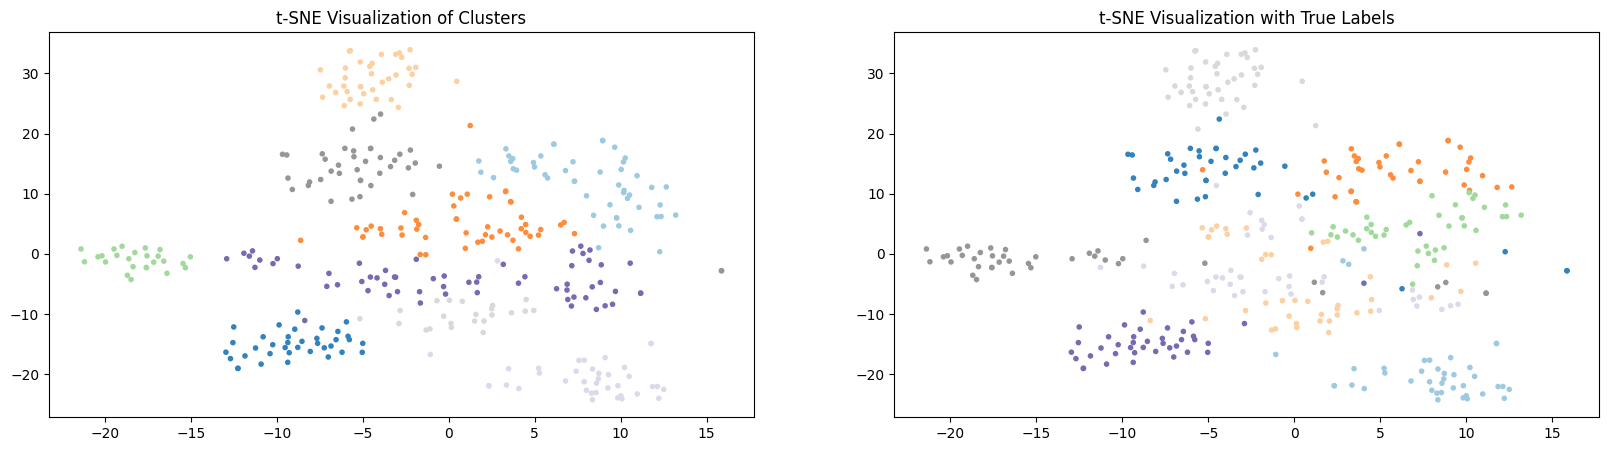

Precision: 0.8049445272396093
Recall: 0.75
Accuracy: 0.75


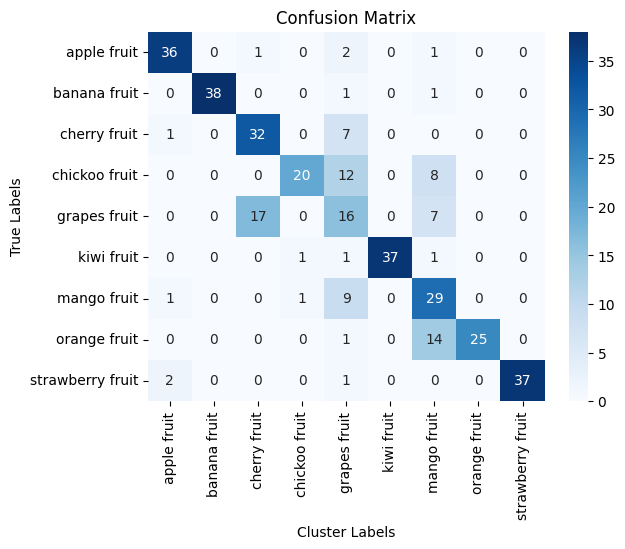

Misclassified Images:
images_dataset/apple fruit\Image_16.jpg
images_dataset/apple fruit\Image_22.jpg
images_dataset/apple fruit\Image_37.jpg
images_dataset/apple fruit\Image_39.jpg
images_dataset/banana fruit\Image_14.jpg
images_dataset/banana fruit\Image_35.jpg
images_dataset/cherry fruit\Image_16.jpg
images_dataset/cherry fruit\Image_23.jpg
images_dataset/cherry fruit\Image_24.jpg
images_dataset/cherry fruit\Image_25.jpg
images_dataset/cherry fruit\Image_28.jpg
images_dataset/cherry fruit\Image_40.jpg
images_dataset/cherry fruit\Image_7.jpg
images_dataset/cherry fruit\Image_8.jpg
images_dataset/chickoo fruit\Image_11.jpg
images_dataset/chickoo fruit\Image_15.png
images_dataset/chickoo fruit\Image_18.jpg
images_dataset/chickoo fruit\Image_19.jpg
images_dataset/chickoo fruit\Image_2.jpg
images_dataset/chickoo fruit\Image_20.jpg
images_dataset/chickoo fruit\Image_21.jpg
images_dataset/chickoo fruit\Image_22.jpg
images_dataset/chickoo fruit\Image_23.jpg
images_dataset/chickoo fruit\Imag

In [5]:

with open('features_labels.pkl', 'rb') as f:
    extracted_feature_list, eval_image_names, labels, dirs_visited = pickle.load(f)
print("loaded features shape",extracted_feature_list.shape)

#feature reduction 2D using tsne (for visualization only)
tsne = TSNE(n_components=2)
pca_object=pca_extraction(extracted_feature_list,0.9)           #select PCA variance
tsne_result=tsne.fit_transform(pca_object.pca_result)

#Kmeans clustering using PCA reduced features
Kmeans= KMeans(n_clusters=9,init='k-means++')
Kmeans.fit(pca_object.pca_result)
Kmeans_labels=Kmeans.labels_

#  Visualize the clustering results
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=Kmeans_labels, cmap='tab20c',s=9)
plt.title('t-SNE Visualization of Clusters')

#  Compare with true labels
plt.subplot(1,2,2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab20c',s=9)
plt.title('t-SNE Visualization with True Labels')
plt.show()

#clustering result
accuracy=adjusted_rand_score(Kmeans_labels,labels)

#confusion matrix
conf_matrix = confusion_matrix(labels, Kmeans_labels)

#creating a dictionary that maps the "cluster labels" number to the most likely correct "true labels" number
row_ind, col_ind = linear_sum_assignment(-conf_matrix)
label_mapping = dict(zip(col_ind, row_ind))
mapped_Kmeans_labels = np.array([label_mapping[label] for label in Kmeans_labels])
remapped_conf_matrix = confusion_matrix(labels, mapped_Kmeans_labels)

#how often the positive predictions are correct?
precision = precision_score(labels, mapped_Kmeans_labels, average='weighted')
# can an ML model find all instances of the positive class?
recall = recall_score(labels, mapped_Kmeans_labels, average='weighted')
#how often the model is right? (if the class numbers are unbalanced between TP and TN, the accuracy will fail)
accuracy = accuracy_score(labels, mapped_Kmeans_labels)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

#retrieve class names from the path discovery at beginning
dirs_basename= [os.path.basename(d) for d in dirs_visited]

# Visualize the remapped confusion matrix using a heatmap
sns.heatmap(remapped_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dirs_basename[1:len(dirs_basename)],
            yticklabels=dirs_basename[1:len(dirs_basename)])
plt.xlabel('Cluster Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

missed_images=[]
missed_indices= np.where(labels != mapped_Kmeans_labels)[0]
missed_images = eval_image_names[missed_indices]

print("Misclassified Images:")
for img in missed_images:
    print(img)
if 'features' in globals():
    del features
if 'extracted_feature_list' in globals():
    del extracted_feature_list

<h2>model Kmeans evaluation</h2>

using vgg16
1/1 [==============================] - 0s 74ms/step
feature list shape (65, 4096)
reduced feature list shape (65, 125)
Precision: 0.8122039072039071
Recall: 0.7692307692307693
Accuracy: 0.7692307692307693


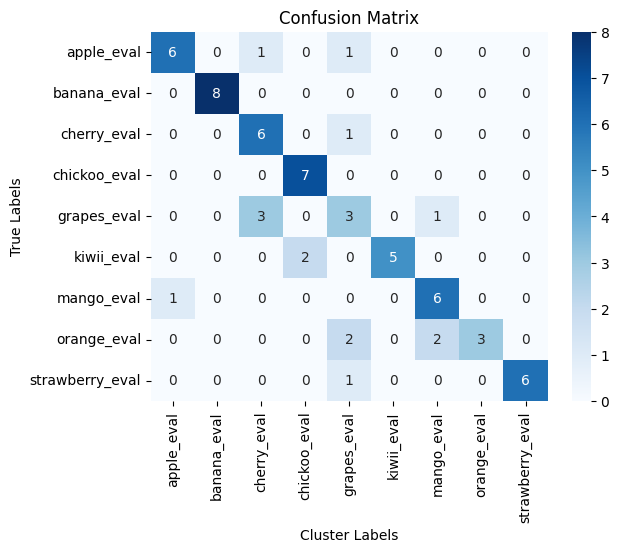

real name: apple (1).jpg    predicted_SVM_labels name: cherry_eval
real name: apple (2).jpg    predicted_SVM_labels name: apple_eval
real name: apple (3).jpg    predicted_SVM_labels name: apple_eval
real name: apple (4).jpg    predicted_SVM_labels name: apple_eval
real name: apple (5).jpg    predicted_SVM_labels name: apple_eval
real name: apple (6).jpg    predicted_SVM_labels name: apple_eval
real name: apple (7).jpg    predicted_SVM_labels name: grapes_eval
real name: apple (8).jpg    predicted_SVM_labels name: apple_eval
real name: banana (1).jpg    predicted_SVM_labels name: banana_eval
real name: banana (2).jpg    predicted_SVM_labels name: banana_eval
real name: banana (3).jpg    predicted_SVM_labels name: banana_eval
real name: banana (4).jpg    predicted_SVM_labels name: banana_eval
real name: banana (5).jpg    predicted_SVM_labels name: banana_eval
real name: banana (6).jpg    predicted_SVM_labels name: banana_eval
real name: banana (7).jpg    predicted_SVM_labels name: banana

In [6]:

img_dir2='eval_dataset/'
eval_features=[]

paths= path_discovery(img_dir2)
if(select_method==feature_methods[0]):
    print("using vgg16")
    for i in paths.img_paths:
        features = VGG16_features(i, base_model, layer_name='fc2',visualize=False)
        eval_features.append(features)
              
elif(select_method==feature_methods[1]):
    print("using autoencoder")
    with tf.device('/CPU:0'):
        autoencoder_model= tf.keras.models.load_model('autoencoder_model')
        encoder_model= Model(inputs=autoencoder_model.input,outputs=autoencoder_model.get_layer('encoder').get_layer('bottleneck').output)
        
        res=input_preprocessing(paths.img_paths)
        feature_vector= np.array(res.feature_vector)
        feature_vector=feature_vector/255         
        eval_features=encoder_model.predict(feature_vector)
        
    del  res
else:
    raise Exception("no extraction method valid")


eval_features = np.array(eval_features)
eval_image_names = np.array(paths.img_paths)
eval_image_names= [os.path.basename(d) for d in eval_image_names]


print('feature list shape', eval_features.shape)

#apply transformation matrix of PCA, previously calculated, to reduce feature vector size
eval_features=pca_object.pca.transform(eval_features)

print('reduced feature list shape', eval_features.shape)

pred_clusters=Kmeans.predict(eval_features)
#print('predicted_SVM_labels cluster',pred_clusters)

#using the mapping dictionary created in the training phase
mapped_Kmeans_labels = np.array([label_mapping[label] for label in pred_clusters])
#print('mapped predicted_SVM_labels cluster',mapped_Kmeans_labels)


remapped_conf_matrix = confusion_matrix(paths.labels, mapped_Kmeans_labels)

#how often the positive predictions are correct?
precision = precision_score(paths.labels, mapped_Kmeans_labels, average='weighted')
# can an ML model find all instances of the positive class?
recall = recall_score(paths.labels, mapped_Kmeans_labels, average='weighted')
#ow often the model is right? (if the class numbers are unbalanced between TP and TN, the accuracy will fail)
accuracy = accuracy_score(paths.labels, mapped_Kmeans_labels)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

#retrieve class names from the path discovery at beginning
dirs_basename= [os.path.basename(d) for d in paths.dirs_visited]

# Visualize the remapped confusion matrix using a heatmap
sns.heatmap(remapped_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dirs_basename[1:len(dirs_basename)],
            yticklabels=dirs_basename[1:len(dirs_basename)])
plt.xlabel('Cluster Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


for a in range(len(mapped_Kmeans_labels)):
    print('real name:',eval_image_names[a], '   predicted_SVM_labels name:', dirs_basename[mapped_Kmeans_labels[a]])


del eval_features, paths

<h2>model SVM training</h2>
(supervised method)

In [7]:
from sklearn.svm import SVC

with open('features_labels.pkl', 'rb') as f:
    extracted_feature_list, eval_image_names, labels, dirs_visited= pickle.load(f)
    
#train 9 SVM one for each class
kernel= 'linear'
max_iterations=500

models = [SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),
          SVC(kernel=kernel, max_iter=max_iterations, probability=True),]


for i in range(9):
    models[i].fit(extracted_feature_list, labels==i+1)


model predictions on evaluation data

using vgg16
1/1 [==============================] - 0s 75ms/step
Precision: 0.9596153846153846
Recall: 0.9538461538461539
Accuracy: 0.9538461538461539


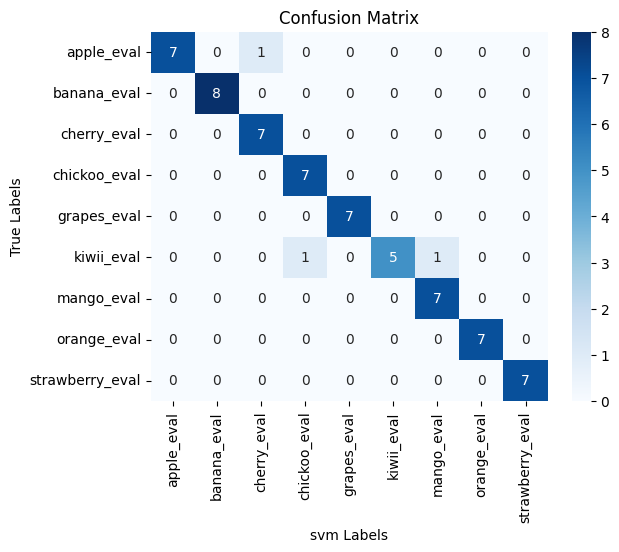

real name: apple (1).jpg    predicted name: cherry_eval
real name: apple (2).jpg    predicted name: apple_eval
real name: apple (3).jpg    predicted name: apple_eval
real name: apple (4).jpg    predicted name: apple_eval
real name: apple (5).jpg    predicted name: apple_eval
real name: apple (6).jpg    predicted name: apple_eval
real name: apple (7).jpg    predicted name: apple_eval
real name: apple (8).jpg    predicted name: apple_eval
real name: banana (1).jpg    predicted name: banana_eval
real name: banana (2).jpg    predicted name: banana_eval
real name: banana (3).jpg    predicted name: banana_eval
real name: banana (4).jpg    predicted name: banana_eval
real name: banana (5).jpg    predicted name: banana_eval
real name: banana (6).jpg    predicted name: banana_eval
real name: banana (7).jpg    predicted name: banana_eval
real name: banana (8).jpg    predicted name: banana_eval
real name: cherry (1).jpg    predicted name: cherry_eval
real name: cherry (2).jpg    predicted name: c

In [8]:
img_dir2='eval_dataset/'
eval_features=[]

paths= path_discovery(img_dir2)
if(select_method==feature_methods[0]):
    print("using vgg16")
    for i in paths.img_paths:
        features = VGG16_features(i, base_model, layer_name='fc2',visualize=False)
        eval_features.append(features)
        
        
elif(select_method==feature_methods[1]):
    print("using autoencoder")
    with tf.device('/CPU:0'):
        encoder= tf.keras.models.load_model('autoencoder_model')
        encoder_model= Model(inputs=encoder.input, outputs=encoder.get_layer('bottleneck').output)
        
        res=input_preprocessing(paths.img_paths)
        feature_vector= np.array(res.feature_vector)
        feature_vector=feature_vector/255         
        eval_features=encoder_model.predict(feature_vector)
        
    del  res
else:
    raise Exception("no extraction method valid")


eval_features = np.array(eval_features)
eval_image_names = np.array(paths.img_paths)
eval_image_names= [os.path.basename(d) for d in eval_image_names]



predict_score=[]
for i in range(9):
    #calculate probability of all samples for each model, then take only 2nd column
    #which is the prob. that the sample BELONGS to that class (wherease [:,0] is the prob. to not belong)
    predict_score.append(models[i].predict_proba(eval_features)[:,1])


predict_score=np.asarray(predict_score)
predicted_SVM_labels=np.argmax(predict_score,axis=0) +1 #because true labels start from 1

conf_matrix1= confusion_matrix(paths.labels,predicted_SVM_labels)

#how often the positive predictions are correct?
precision = precision_score(paths.labels, predicted_SVM_labels, average='weighted')
# can an ML model find all instances of the positive class?
recall = recall_score(paths.labels, predicted_SVM_labels, average='weighted')
#ow often the model is right? (if the class numbers are unbalanced between TP and TN, the accuracy will not give exhaustive results)
accuracy = accuracy_score(paths.labels, predicted_SVM_labels)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")


dirs_basename= [os.path.basename(d) for d in paths.dirs_visited]
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dirs_basename[1:len(dirs_basename)],
            yticklabels=dirs_basename[1:len(dirs_basename)])

plt.xlabel('svm Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

for a in range(len(predicted_SVM_labels)):
    print('real name:',eval_image_names[a], '   predicted name:', dirs_basename[predicted_SVM_labels[a]])
    
del eval_features

<h2>model DBscan training with PCA reduced features</h2>

array1 features (360, 4096)
number of PCA components explaining 70.0% of variance: 34
dbscan number of clusters 22
Precision: 0.39044289044289043
Recall: 0.2463404136131409
Accuracy: 0.6180555555555556


c:\Users\frenc\anaconda3\envs\machine_learning_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


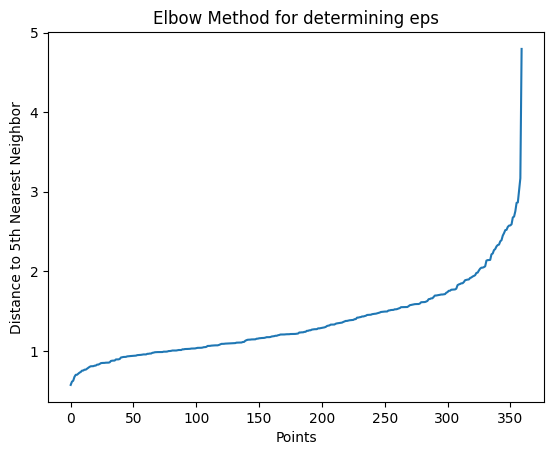

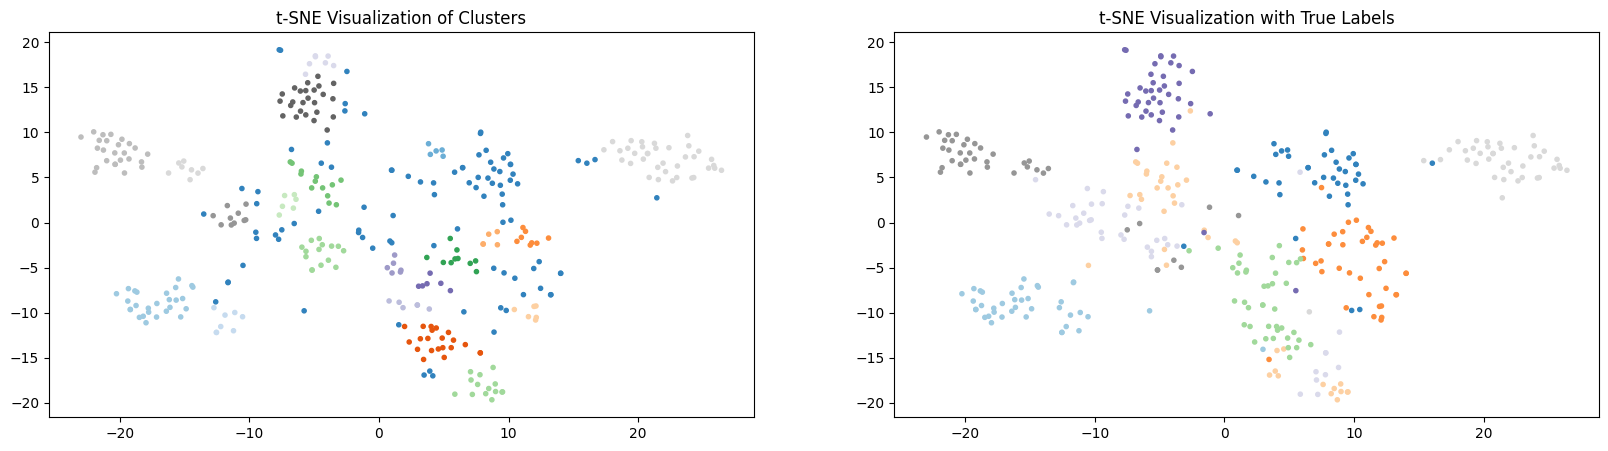

In [9]:
with open('features_labels.pkl', 'rb') as f:
    extracted_feature_list, eval_image_names, labels, dirs_visited = pickle.load(f)

print("array1 features",extracted_feature_list.shape)

#feature reduction 2D using tsne (for visualization only)
tsne = TSNE(n_components=2)
pca_object=pca_extraction(extracted_feature_list,0.7)
tsne_result=tsne.fit_transform(pca_object.pca_result)

#DBscan clustering using PCA reduced features
dbscan=DBSCAN(eps=1.5,min_samples=5)
dbscan_labels = dbscan.fit_predict(tsne_result)
print("dbscan number of clusters",np.max(dbscan_labels)+1)

mask = dbscan_labels != -1
filtered_dbscan_labels = dbscan_labels[mask]
filtered_true_labels = labels[mask]

#confusion matrix
conf_matrix = confusion_matrix(filtered_true_labels, filtered_dbscan_labels)
#creating a dictionary that maps the "cluster labels" number to the most likely correct "true labels" number
#this time the cluster labels can be more than the true labels, 
row_ind, col_ind = linear_sum_assignment(-conf_matrix)
label_mapping = dict(zip(col_ind, row_ind))
mapped_labels = np.zeros_like(filtered_dbscan_labels)
for i, j in zip(row_ind, col_ind):
    mapped_labels[filtered_dbscan_labels == j] = i


accuracy = accuracy_score(filtered_true_labels, mapped_labels)
precision = precision_score(filtered_true_labels, mapped_labels, average='macro')
recall = recall_score(filtered_true_labels, mapped_labels, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

#find the distances of each point from the first 5 nearest neighbour
#this algorithm is done to find the best value for "eps" dbscan parameter
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(tsne_result)
distances, indices = neighbors_fit.kneighbors(tsne_result)

# Sort and plot the distances of each point from the 3rd neighbour
distances = np.sort(distances, axis=0)
distances = distances[:, 3]
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.title('Elbow Method for determining eps')
plt.show()

#  Visualize the clustering results
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=dbscan_labels, cmap='tab20c',s=9)
plt.title('t-SNE Visualization of Clusters')

#  Compare with true labels
plt.subplot(1,2,2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab20c',s=9)
plt.title('t-SNE Visualization with True Labels')
plt.show()




<h2>autoencoder training for feature extraction</h2>

result will be shown after process finished, check gpu memory usage

return code:  0
error 2024-07-04 11:09:14.064401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 11:09:14.448965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5444 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-07-04 11:09:15.639823: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.

output subprocess called

Num GPUs Available:  1
input preprocessing...
preprocessing done
Shape of feature_vectors: (360, 37632)


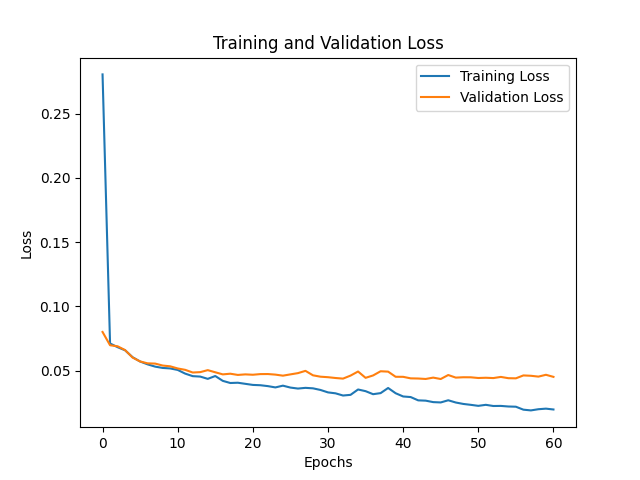

In [2]:
import subprocess
from IPython.display import display

paths = path_discovery('images_dataset/')

#this subprocess thinghy is done because for some reason, tensorflow won't release the GPU memory after training finished, and any
#other method to clean the memory, causes the kernel to crash on the next cell. with subprocess, the memory is released after finishing
#if ypur gpu memory cannot load the model, try to execute it on CPU, instruction are on the "train_autoencoder.py" file
def run_training_subprocess(g1):
    
    print("result will be shown after process finished, check gpu memory usage\n")
    
    res = subprocess.run(["python", 'train_autoencoder.py']+g1,text=True, capture_output=True)

    print("return code: ",res.returncode)
    print("error",res.stderr)
    print("output",res.stdout)

    img = Image.open('autoencoder_val_loss.png')
    display(img)

    
encoder_result = run_training_subprocess(paths.img_paths)


<h2>model autoencoder evaluation</h2>

input preprocessing...
preprocessing done
Shape of feature_vectors: (65, 37632)
3/3 [==============================] - 0s 32ms/step


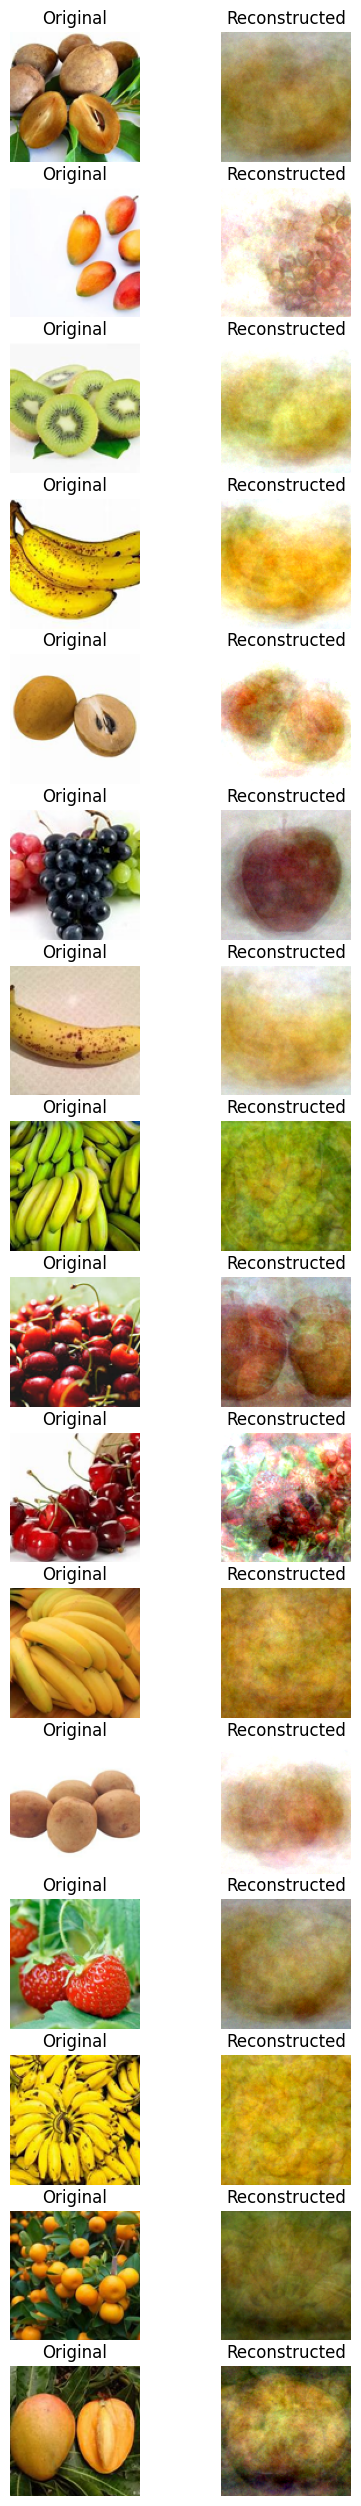

In [3]:
from tensorflow.keras.backend import clear_session


clear_session()
gc.collect()


paths = path_discovery('eval_dataset/')

def plot_images(original_images, reconstructed_images, n):
    random_indexes=np.random.choice(len(original_images),n,replace=False)
    
    plt.figure(figsize=(5, n * 2)) 
    for i , idx in enumerate(random_indexes):
        # Original images
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(original_images[idx])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed images
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(reconstructed_images[idx])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()
    
res=input_preprocessing(paths.img_paths)
        
feature_vector= np.array(res.feature_vector)
feature_vector=feature_vector/255

print(f"Shape of feature_vectors: {feature_vector.shape}") 

with tf.device('/CPU:0'):
    autoencoder_model= tf.keras.models.load_model('autoencoder_model')
    reconstructed_images=autoencoder_model.predict(feature_vector)
    
reconstructed_images = np.clip(reconstructed_images, 0, 1)   
reconstructed_images = reconstructed_images.reshape(-1, 112, 112,3)

plot_images(res.original_image ,reconstructed_images, int(len(res.original_image)/4) ) 
